In [1]:
import numpy as np
import os
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import librosa

In [2]:
import tensorflow as tf
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import MaxPooling1D
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
!unzip allData_threeEmotions.zip

Archive:  allData_threeEmotions.zip
  inflating: x_data.npy              
  inflating: y_data.npy              


In [4]:
# load X and Y from npy files
x_path = './x_data.npy'
y_path = './y_data.npy'
X = np.load(x_path)
Y = np.load(y_path)

print(X.shape)
print(Y.shape)

(5768, 40)
(5768,)


In [5]:
X_train_0, X_test, y_train_0, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_0, y_train_0, test_size=0.18, random_state=42) # 0.18 x 0.85 = 0.15

In [6]:
print(X_train.shape, X_val.shape, X_test.shape)

(4019, 40) (883, 40) (866, 40)


In [7]:
# count occurences of each emotion
train_count = [0]*3
val_count = [0]*3
test_count = [0]*3

for e in y_train:
    train_count[e] += 1

for e in y_val:
    val_count[e] += 1

for e in y_test:
    test_count[e] += 1

print(train_count, val_count, test_count)

[1350, 1353, 1316] [289, 271, 323] [284, 298, 284]


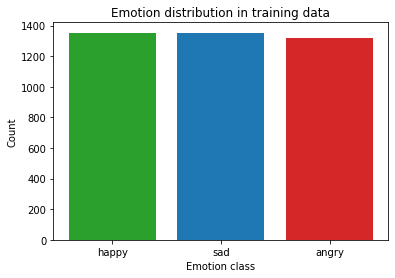

In [8]:
from matplotlib import pyplot

fig = plt.figure()
c = ['tab:green', 'tab:blue', 'tab:red']

emos = ['happy', 'sad', 'angry']
plt.bar(emos, train_count, color=c)
plt.xlabel("Emotion class")
plt.ylabel("Count")
plt.title("Emotion distribution in training data")
plt.show()

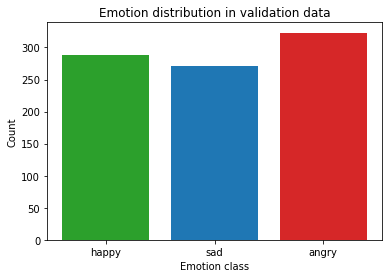

In [9]:
from matplotlib import pyplot

fig = plt.figure()

plt.bar(emos, val_count, color=c)
plt.xlabel("Emotion class")
plt.ylabel("Count")
plt.title("Emotion distribution in validation data")
plt.show()

In [85]:
#####################################################
#                 Model Section                     #
#####################################################

x_traincnn = np.expand_dims(X_train, axis=2)
x_valcnn = np.expand_dims(X_val, axis=2)

print(x_traincnn.shape, x_valcnn.shape)

# model = Sequential()
# model.add(BatchNormalization())
# model.add(Conv1D(64, 5, padding='same',
#                     input_shape=(40, 1)))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(Flatten())
# model.add(Dense(3))
# model.add(Activation('softmax'))
model = Sequential()
model.add(BatchNormalization())
model.add(Conv1D(32, 3, padding='same',
                    input_shape=(40, 1)))
model.add(Activation('relu'))
model.add(tf.keras.layers.MaxPool1D())
model.add(Conv1D(64, 3, padding='same'))
model.add(Dropout(0.2))
model.add(tf.keras.layers.MaxPool1D())
model.add(Conv1D(128, 3, padding='same'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(3))
model.add(Activation('softmax'))

print(model.summary)

model.compile(loss='sparse_categorical_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])

history = model.fit(x_traincnn, y_train,
                        batch_size=64, epochs=60,
                        validation_data=(x_valcnn, y_val))

(4019, 40, 1) (883, 40, 1)
<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7ff91bdbc310>>
Epoch 1/60
63/63 [==============================] - 2s 18ms/step - loss: 0.9285 - accuracy: 0.5476 - val_loss: 0.7910 - val_accuracy: 0.6319
Epoch 2/60
63/63 [==============================] - 1s 15ms/step - loss: 0.7622 - accuracy: 0.6559 - val_loss: 0.7705 - val_accuracy: 0.6489
Epoch 3/60
63/63 [==============================] - 1s 15ms/step - loss: 0.7305 - accuracy: 0.6601 - val_loss: 0.7409 - val_accuracy: 0.6625
Epoch 4/60
63/63 [==============================] - 1s 15ms/step - loss: 0.7242 - accuracy: 0.6646 - val_loss: 0.8312 - val_accuracy: 0.6523
Epoch 5/60
63/63 [==============================] - 1s 16ms/step - loss: 0.7073 - accuracy: 0.6842 - val_loss: 0.7239 - val_accuracy: 0.6750
Epoch 6/60
63/63 [==============================] - 1s 15ms/step - loss: 0.6923 - accuracy: 0.6974 - val_loss: 0.7437 - val_accuracy: 0.6614
Epoch 7/60
63/63 [===============

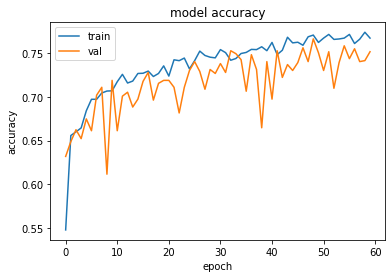

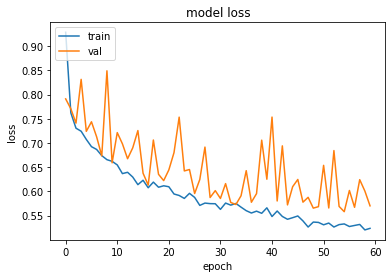

In [87]:
# Model plots
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
index_to_emotion = {
    0:"happy",
    1:"sad",
    2:"angry",
    3:"disgust",
    4:"fear",
    5:"neutral"
}

In [24]:
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=4):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  return audio

In [39]:
x = record(6)

<IPython.core.display.Javascript object>

In [40]:
sample_rate = x.frame_rate

In [41]:
import IPython.display as ipd
ipd.Audio(np.array(x.get_array_of_samples(), dtype = 'float32'), rate=x.frame_rate) # load a NumPy array

In [42]:
sr = x.frame_rate
y = np.array(x.get_array_of_samples(), dtype = 'float32')
x_mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr,n_mfcc=40).T, axis=0)

In [43]:
X_fresh = np.array(x_mfccs)
X_fresh = X_fresh.reshape((1, X_fresh.shape[0]))
X_fresh = np.expand_dims(X_fresh, axis=2)

In [44]:
out = model.predict(X_fresh, verbose=1)

1/1 [==============================] - 0s 24ms/step


In [45]:
# emotion is argmax of out
print(out)
idx = np.argmax(out, axis=1)
print(index_to_emotion[idx[0]])

[[8.711082e-16 3.630011e-27 1.000000e+00]]
angry


In [ ]:
! pip install pydub
! pip install noisereduce
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [47]:
! kaggle datasets download -d tli725/jl-corpus

100% 1.19G/1.20G [00:12<00:00, 89.7MB/s]
100% 1.20G/1.20G [00:12<00:00, 101MB/s] 


In [48]:
!mkdir ./data

In [49]:
%%capture
!unzip jl-corpus.zip -d ./data

In [67]:
emotions = {
  'happy': 0, 
  'sad': 1, 
  'angry': 2
}

processed_data = []

data_path = "/content/data/Raw JL corpus (unchecked and unannotated)/JL(wav+txt)"
for file in os.listdir(data_path):
     filename = os.fsdecode(file)
     file_path = os.path.join(data_path, filename)

     if filename.endswith(".wav"):
         emotion_label = emotions.get(filename.split('_')[1], None)
         if (emotion_label != None):
            processed_data.append([file_path, emotion_label])         
     else:
         continue

In [68]:
print(len(processed_data))

720


In [69]:
def extract_feature(file_name): 

    y, sample_rate = librosa.load(file_name, res_type='kaiser_fast')

    # Don't process corrupted audio signals
    if not np.any(y):
        return None

    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sample_rate,n_mfcc=40).T, axis=0)

    return mfccs

# Obtain features from each wav file
labels = []
features = []

i = 0 # partially save results?
for data in processed_data:
    i += 1
    result = extract_feature(data[0])
    if result is not None:
        labels.append(data[1])
        features.append(result)
    if i%100 == 0:
        print(i)

100
200
300
400
500
600
700


In [73]:
# Create np arrays for data and labels
X_2 = np.array(features)
Y_2 = np.array(labels)
x_2cnn = np.expand_dims(X_2, axis=2)

In [88]:
results = model.evaluate(x_2cnn, Y_2, batch_size=64)

12/12 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.6861


In [57]:
out = model.predict(x_2cnn)

In [58]:
print(out[:15])

[[4.3746926e-02 1.5757621e-03 9.5467728e-01]
 [4.3167382e-02 9.5574564e-01 1.0870511e-03]
 [6.5987357e-03 9.9287170e-01 5.2959891e-04]
 [1.5559679e-01 5.8278161e-01 2.6162153e-01]
 [4.4741163e-01 2.8013349e-01 2.7245492e-01]
 [2.8317395e-01 6.9733310e-01 1.9492986e-02]
 [1.3867611e-01 1.2966430e-04 8.6119425e-01]
 [7.4607253e-01 1.2846391e-01 1.2546362e-01]
 [1.5426628e-01 3.9000800e-01 4.5572573e-01]
 [2.1844506e-01 2.5867586e-04 7.8129631e-01]
 [5.5685335e-01 4.3392770e-02 3.9975387e-01]
 [4.2901707e-01 3.1820554e-02 5.3916234e-01]
 [3.2876708e-02 9.4607204e-01 2.1051258e-02]
 [8.7354504e-02 2.6906916e-01 6.4357632e-01]
 [1.3866563e-01 8.3815020e-01 2.3184126e-02]]


In [59]:
# count occurences of each emotion
JL_count = [0]*3

for e in Y_2:
    JL_count[e] += 1

print(JL_count)

[240, 240, 240]


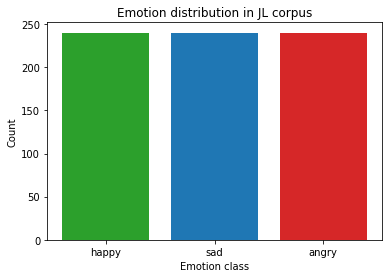

In [60]:
fig = plt.figure()
c = ['tab:green', 'tab:blue', 'tab:red']

emos = ['happy', 'sad', 'angry']
plt.bar(emos, JL_count, color=c)
plt.xlabel("Emotion class")
plt.ylabel("Count")
plt.title("Emotion distribution in JL corpus")
plt.show()